In [12]:
import json
import torch
from transformers import AutoModelForCausalLM
import matplotlib.pyplot as plt
import timesfm
import pandas as pd

### Get data SP

In [13]:
file_path = "../dataset_global/dataset_global.jsonl"

data_list = []

train_list = []
test_list = []

with open(file_path, "r") as f:
    for line in f:
        entry = json.loads(line)
        for key, value in entry.items():
            if key.endswith("_sp"):
                train_list.append(value[:-12])
                test_list.append(value[-12:])

tensor_train = torch.tensor(train_list, dtype=torch.float32)
tensor_test = torch.tensor(test_list, dtype=torch.float32)

print("Train shape:", tensor_train.shape)
print("Test shape:", tensor_test.shape)

Train shape: torch.Size([8, 398])
Test shape: torch.Size([8, 12])


In [14]:
# Guardar min e max de cada série para desnormalização depois
min_vals = tensor_train.min(dim=1, keepdim=True).values
max_vals = tensor_train.max(dim=1, keepdim=True).values

# Normalizar cada série (linha)
tensor_train_scaled = (tensor_train - min_vals) / (max_vals - min_vals)

In [15]:
prediction_length = 12

## Time-Moe

In [8]:
model = AutoModelForCausalLM.from_pretrained(
    "Maple728/TimeMoE-200M",
    trust_remote_code=True,
)

input_timemoe = tensor_train_scaled

output = model.generate(input_timemoe, max_new_tokens=prediction_length) 
output_time_moe_scaled  = output[:, -prediction_length:]

output_time_moe = output_time_moe_scaled * (max_vals - min_vals) + min_vals

c:\Users\alex-\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
W0921 22:12:28.931000 19512 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
c:\Users\alex-\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
mape_series = (torch.abs((tensor_test - output_time_moe) / tensor_test)).mean(dim=1) * 100

for i, mape_val in enumerate(mape_series):
    print(f"Série {i}: MAPE = {mape_val.item():.2f}%")

Série 0: MAPE = 18.84%
Série 1: MAPE = 7.14%
Série 2: MAPE = 20.47%
Série 3: MAPE = 3.01%
Série 4: MAPE = 63.73%
Série 5: MAPE = 8.55%
Série 6: MAPE = 7.00%
Série 7: MAPE = inf%


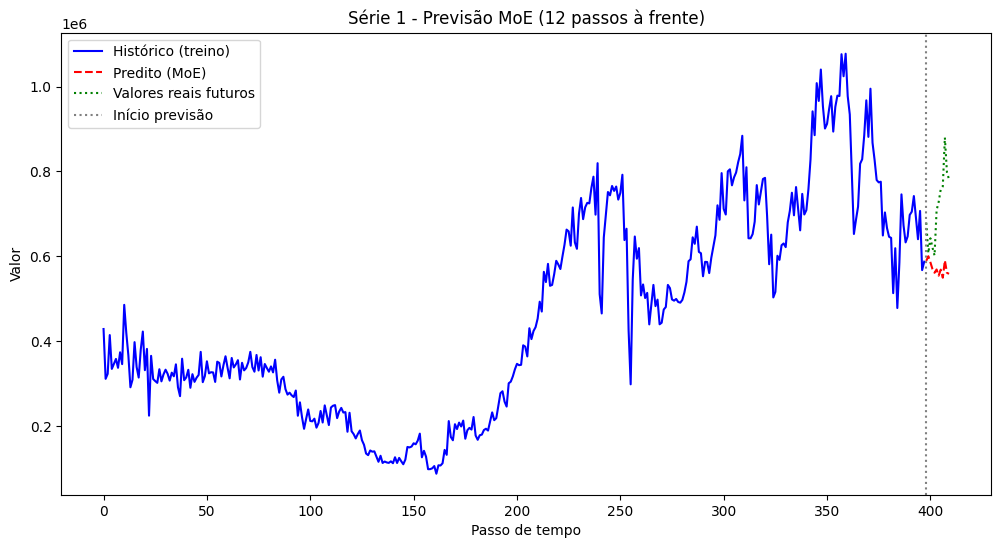

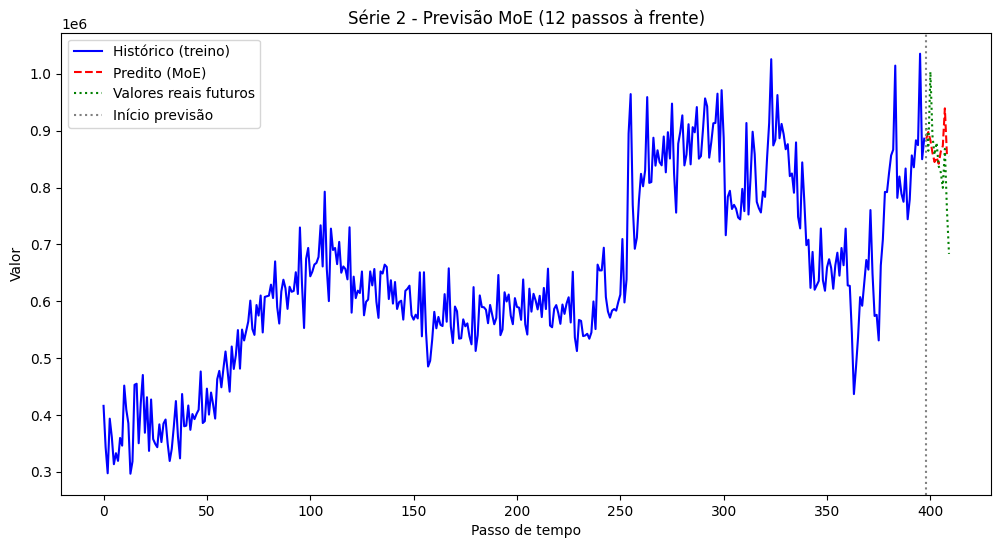

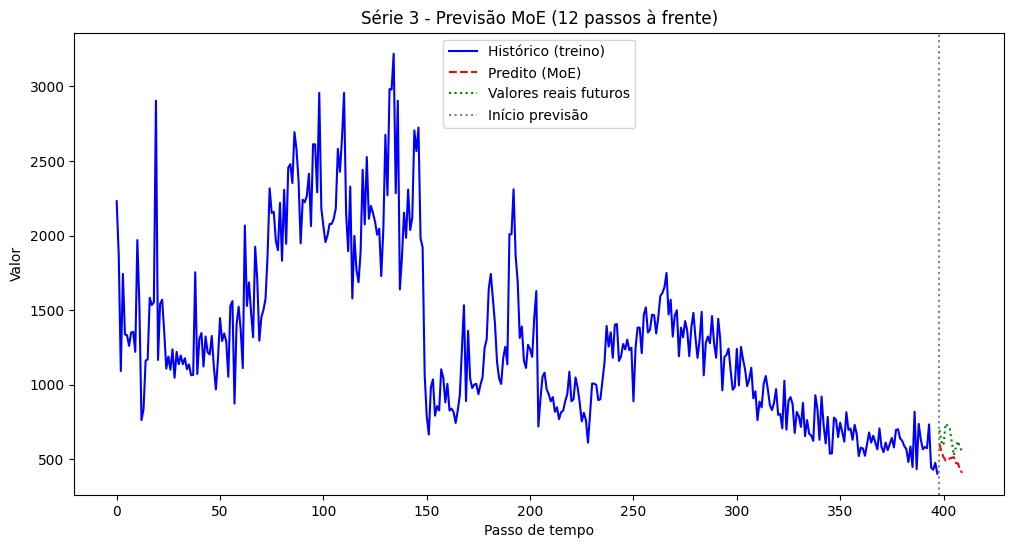

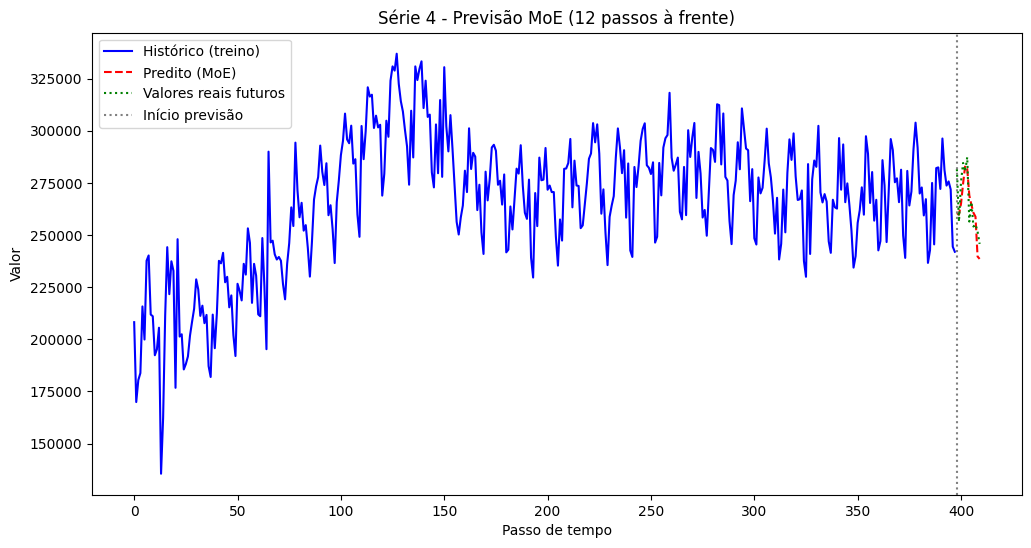

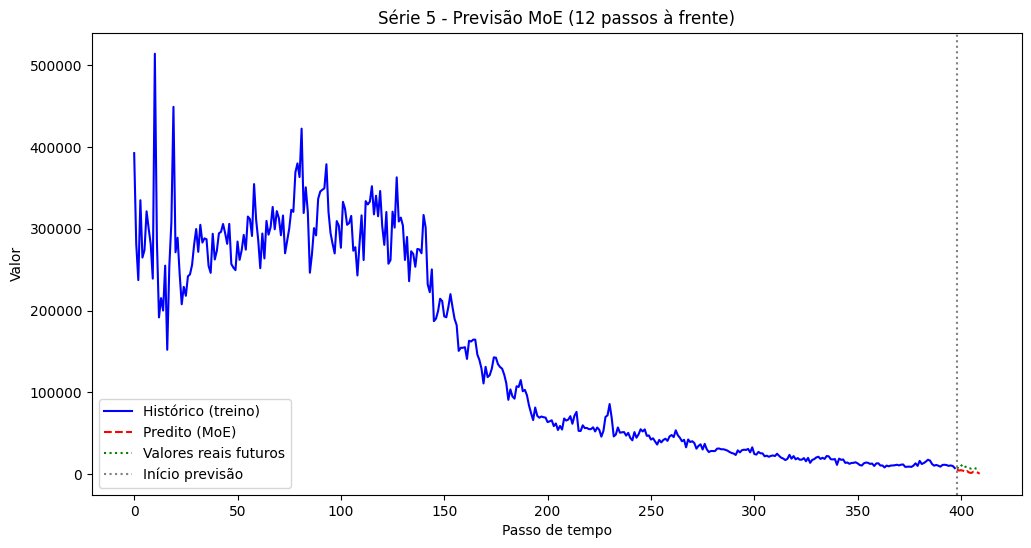

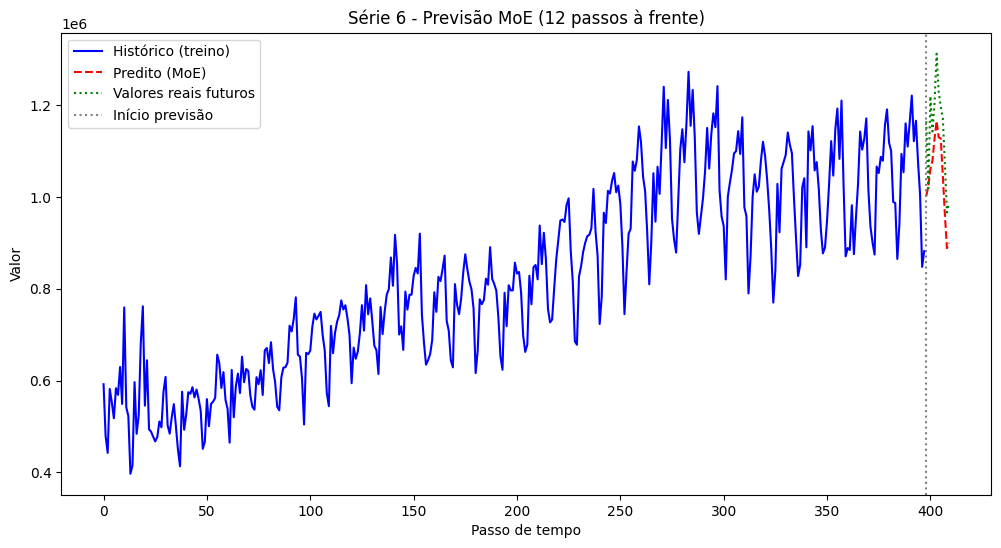

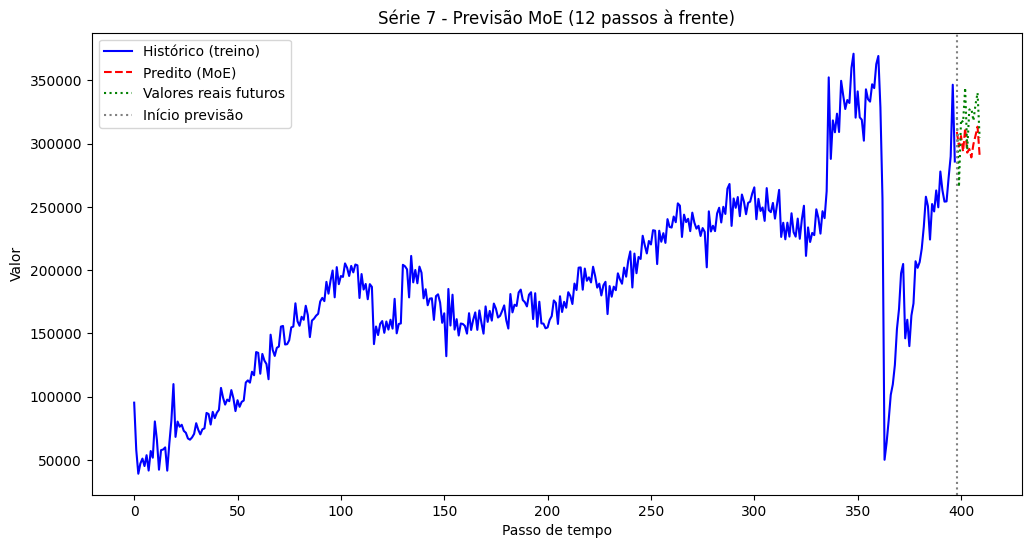

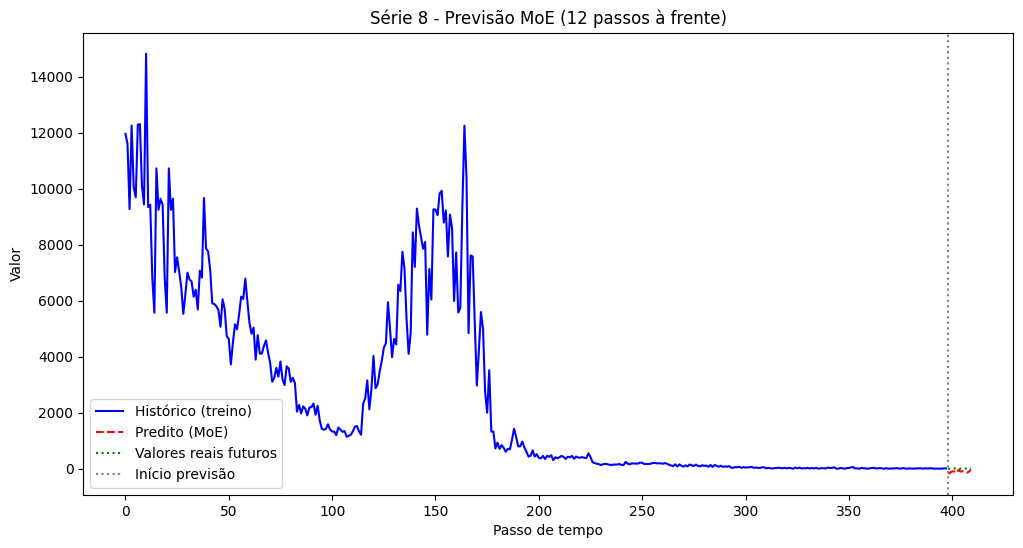

In [10]:
horizon = tensor_test.shape[1]  

num_series = tensor_train.shape[0]

for i in range(num_series):
    series_train = tensor_train[i].numpy()
    series_test = tensor_test[i].numpy()
    pred_moe = output_time_moe[i].numpy()
    
    context_length = len(series_train)
    
    time_axis_context = range(context_length)
    time_axis_pred = range(context_length, context_length + horizon)
    time_axis_real = range(context_length, context_length + horizon)
    
    plt.figure(figsize=(12,6))
    plt.plot(time_axis_context, series_train, label="Histórico (treino)", color="blue")
    plt.plot(time_axis_pred, pred_moe, label="Predito (MoE)", color="red", linestyle="--")
    plt.plot(time_axis_real, series_test, label="Valores reais futuros", color="green", linestyle=":")
    
    plt.axvline(context_length, color="gray", linestyle=":", label="Início previsão")
    plt.legend()
    plt.xlabel("Passo de tempo")
    plt.ylabel("Valor")
    plt.title(f"Série {i+1} - Previsão MoE ({horizon} passos à frente)")
    plt.show()

## Timer

In [16]:
model = AutoModelForCausalLM.from_pretrained(
            "thuml/sundial-base-128m",
            trust_remote_code=True

        )

outputs = [] 

for i in range(tensor_train_scaled.size(0)):      
    past_target = tensor_train_scaled[i].unsqueeze(0)

    forecast = model.generate(
        past_target,
        max_new_tokens=prediction_length,
        num_samples=20
    )

    out_row = torch.as_tensor(forecast.mean(dim=1), dtype=torch.float32).reshape(1, -1)
    outputs.append(out_row)

output_timer_scaled  = torch.cat(outputs, dim=0)

output_timer = output_timer_scaled * (max_vals - min_vals) + min_vals

In [17]:
mape_series = (torch.abs((tensor_test - output_timer) / tensor_test)).mean(dim=1) * 100

for i, mape_val in enumerate(mape_series):
    print(f"Série {i}: MAPE = {mape_val.item():.2f}%")

Série 0: MAPE = 20.96%
Série 1: MAPE = 7.86%
Série 2: MAPE = 14.16%
Série 3: MAPE = 3.40%
Série 4: MAPE = 99.41%
Série 5: MAPE = 7.89%
Série 6: MAPE = 9.16%
Série 7: MAPE = inf%


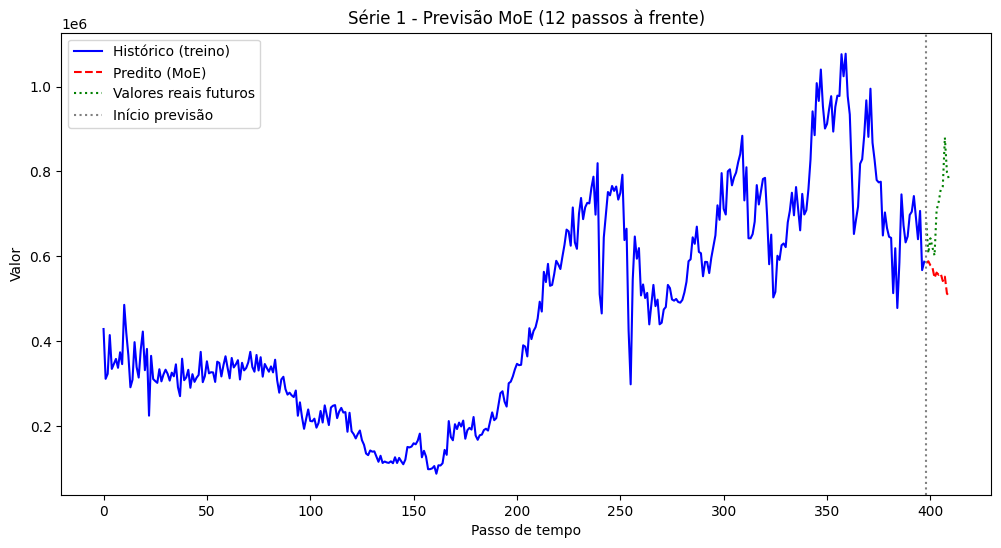

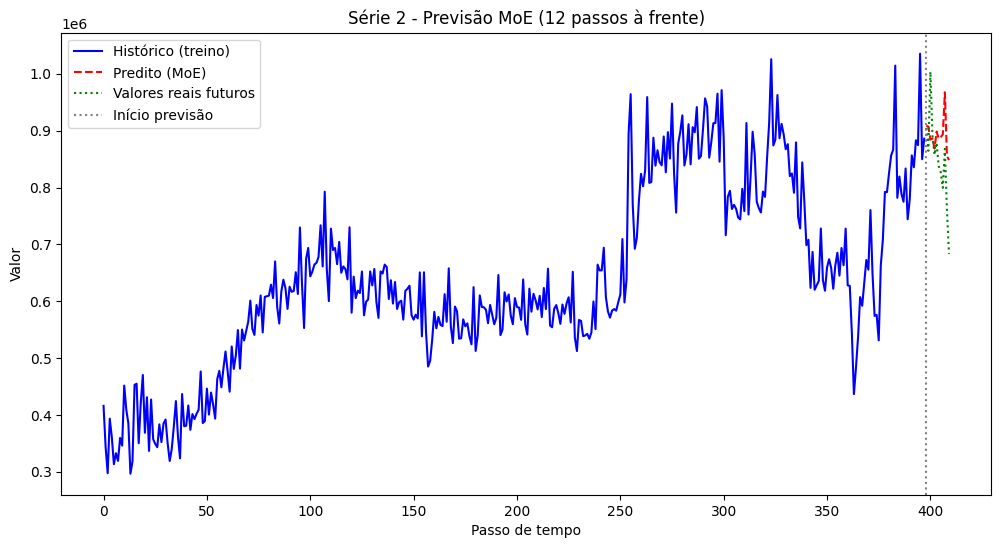

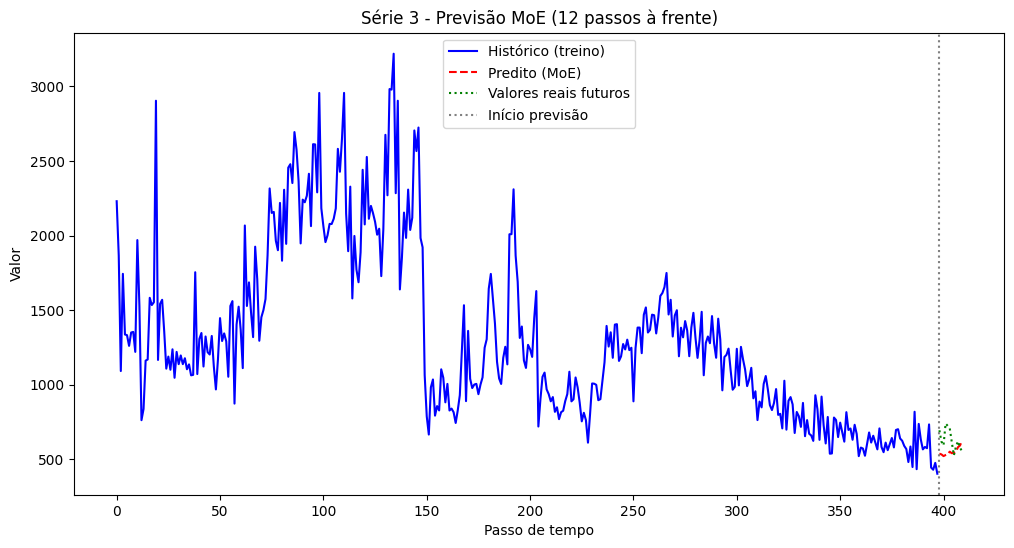

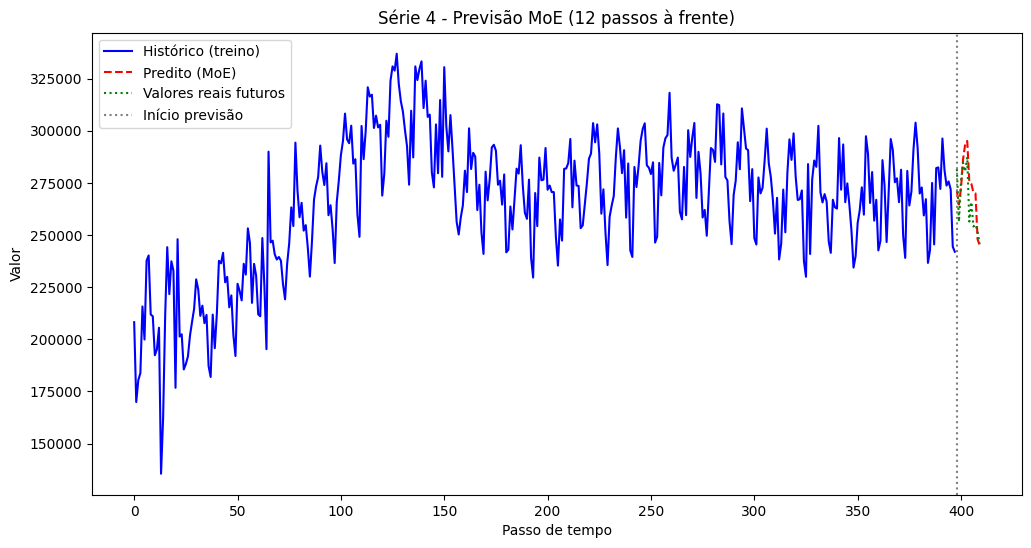

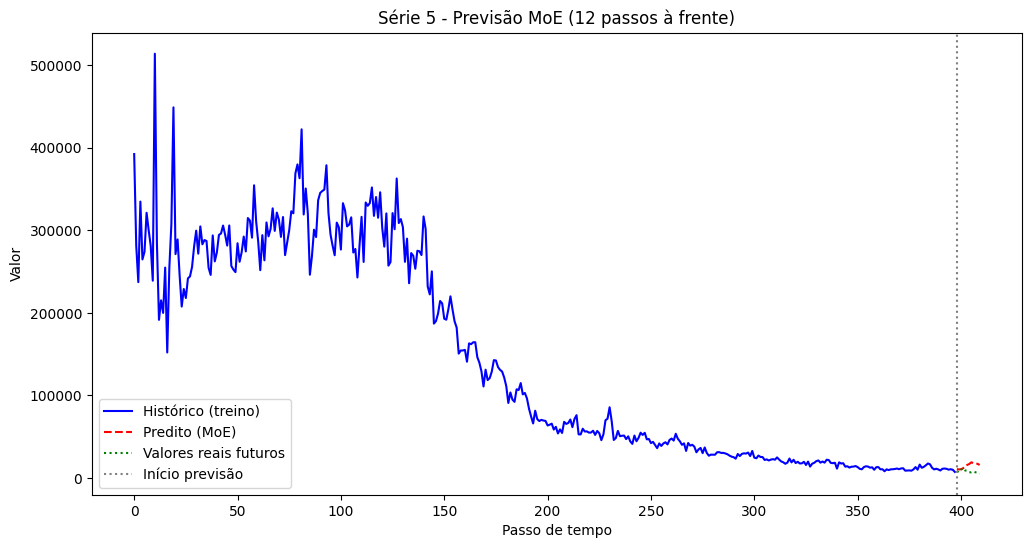

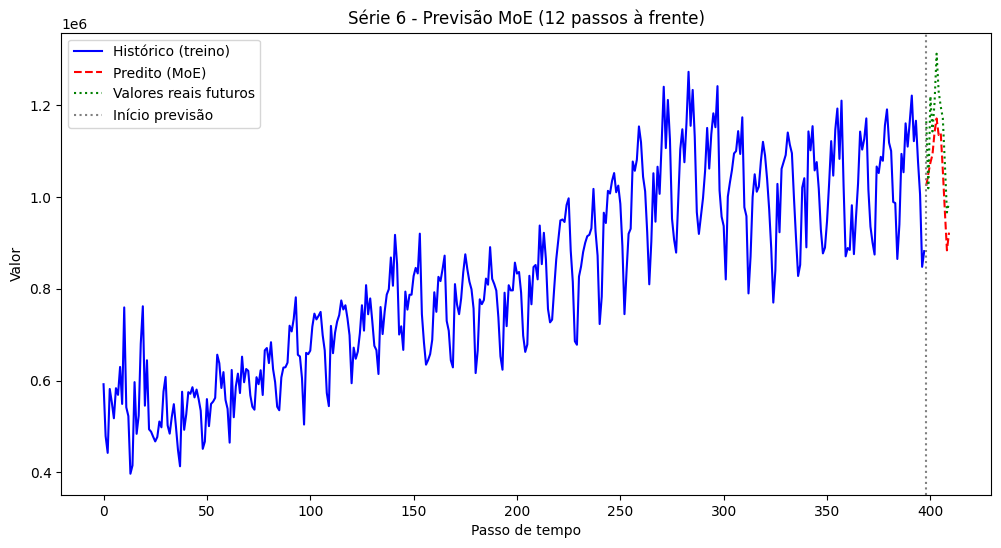

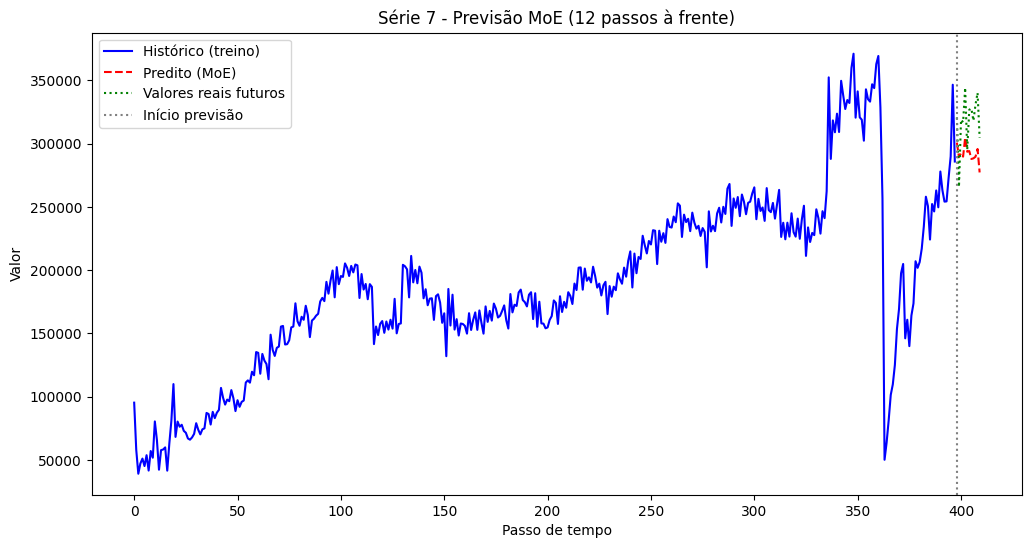

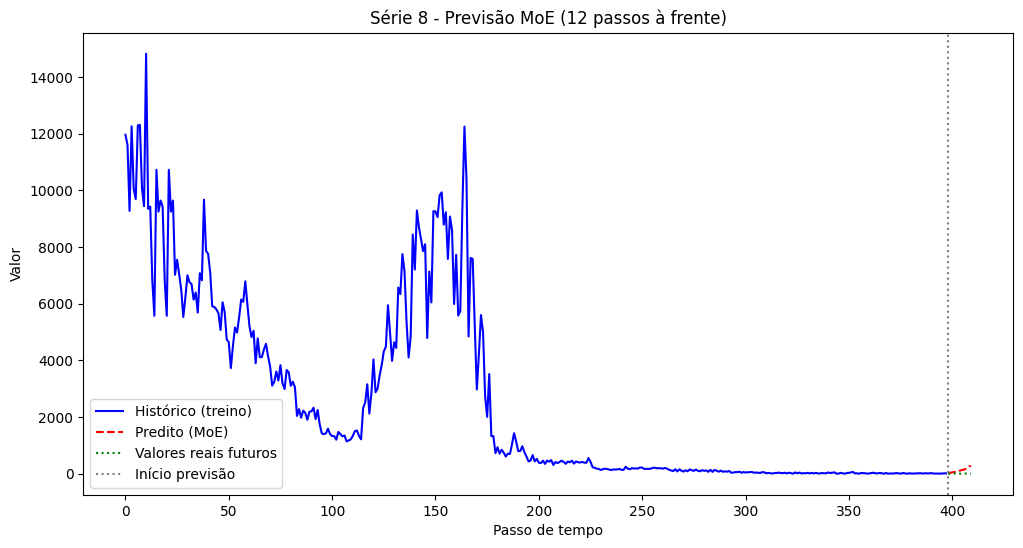

In [18]:
horizon = tensor_test.shape[1]  

num_series = tensor_train.shape[0]

for i in range(num_series):
    series_train = tensor_train[i].numpy()
    series_test = tensor_test[i].numpy()
    pred_moe = output_timer[i].numpy()
    
    context_length = len(series_train)
    
    time_axis_context = range(context_length)
    time_axis_pred = range(context_length, context_length + horizon)
    time_axis_real = range(context_length, context_length + horizon)
    
    plt.figure(figsize=(12,6))
    plt.plot(time_axis_context, series_train, label="Histórico (treino)", color="blue")
    plt.plot(time_axis_pred, pred_moe, label="Predito (MoE)", color="red", linestyle="--")
    plt.plot(time_axis_real, series_test, label="Valores reais futuros", color="green", linestyle=":")
    
    plt.axvline(context_length, color="gray", linestyle=":", label="Início previsão")
    plt.legend()
    plt.xlabel("Passo de tempo")
    plt.ylabel("Valor")
    plt.title(f"Série {i+1} - Previsão MoE ({horizon} passos à frente)")
    plt.show()

## TimesFM

In [19]:
model = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="cpu",
        per_core_batch_size=32,
        horizon_len=prediction_length,
        num_layers=50,
        use_positional_embedding=False,
        context_len=2048,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
    ),
)

input_np = tensor_train_scaled.clone().detach().cpu().numpy()

with torch.no_grad():
    out, experimental_quantile_forecast = model.forecast(input_np) 

output_timesfm_scaled = torch.from_numpy(out).float()

output_timesfm = output_timesfm_scaled * (max_vals - min_vals) + min_vals

Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]


In [20]:
mape_series = (torch.abs((tensor_test - output_timesfm) / tensor_test)).mean(dim=1) * 100

for i, mape_val in enumerate(mape_series):
    print(f"Série {i}: MAPE = {mape_val.item():.2f}%")

Série 0: MAPE = 19.30%
Série 1: MAPE = 8.36%
Série 2: MAPE = 28.29%
Série 3: MAPE = 3.22%
Série 4: MAPE = 55.64%
Série 5: MAPE = 5.88%
Série 6: MAPE = 7.25%
Série 7: MAPE = inf%


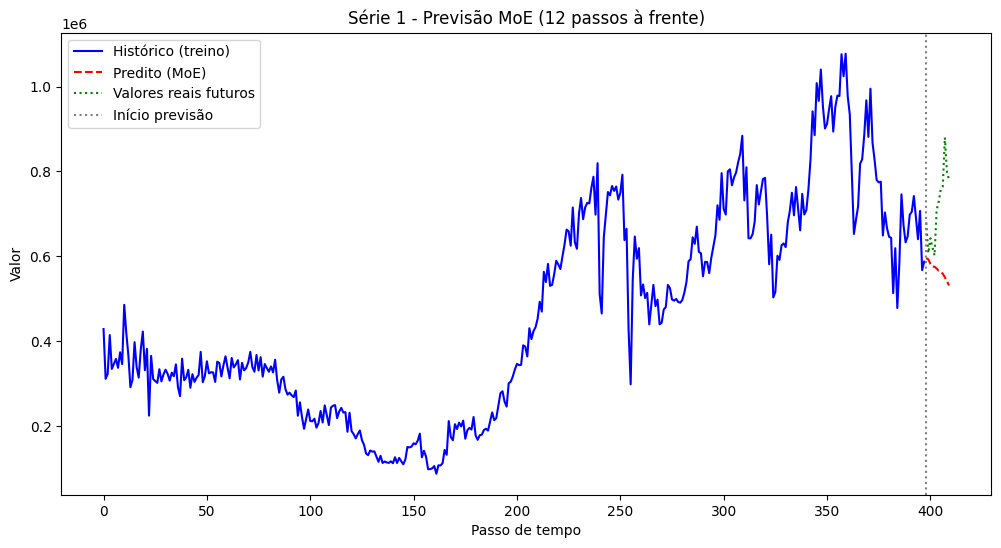

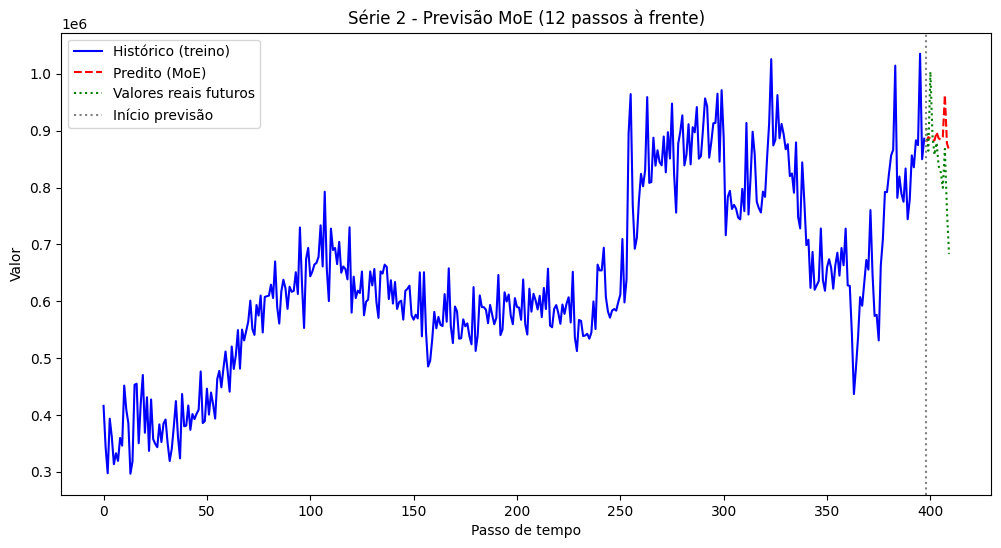

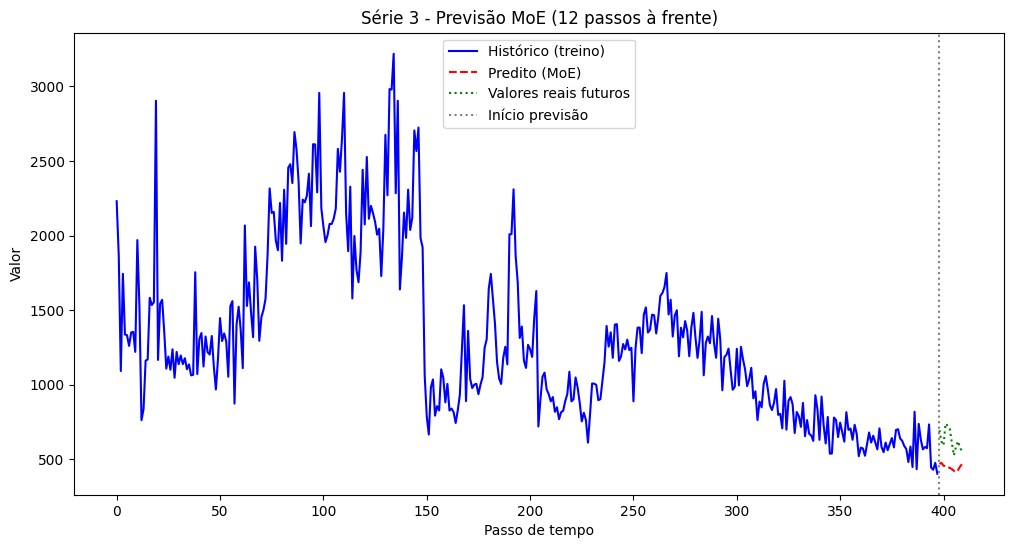

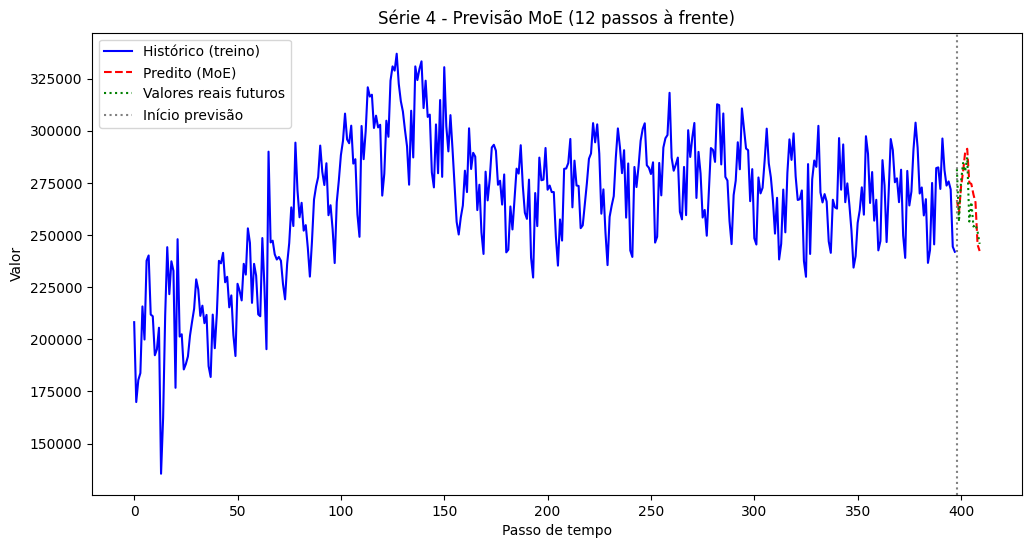

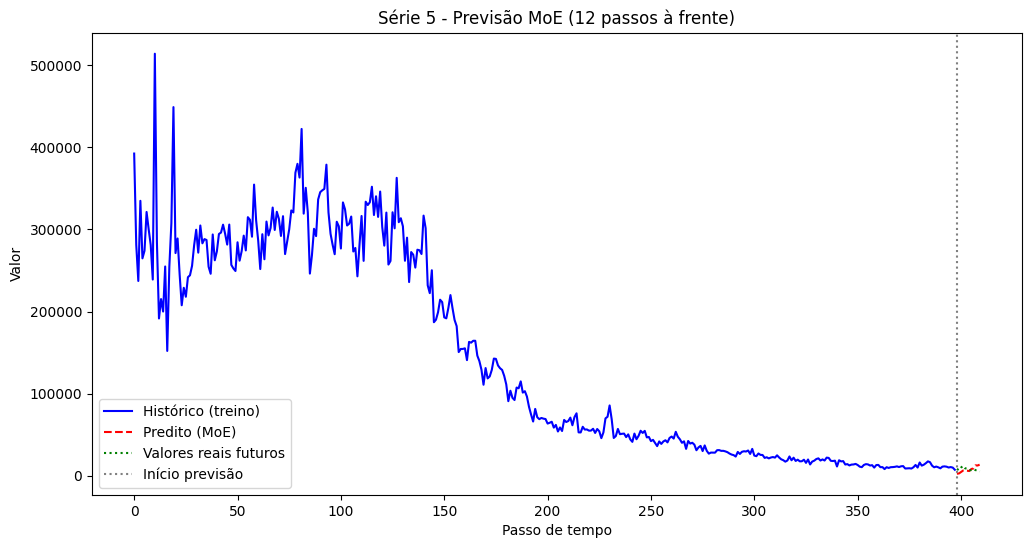

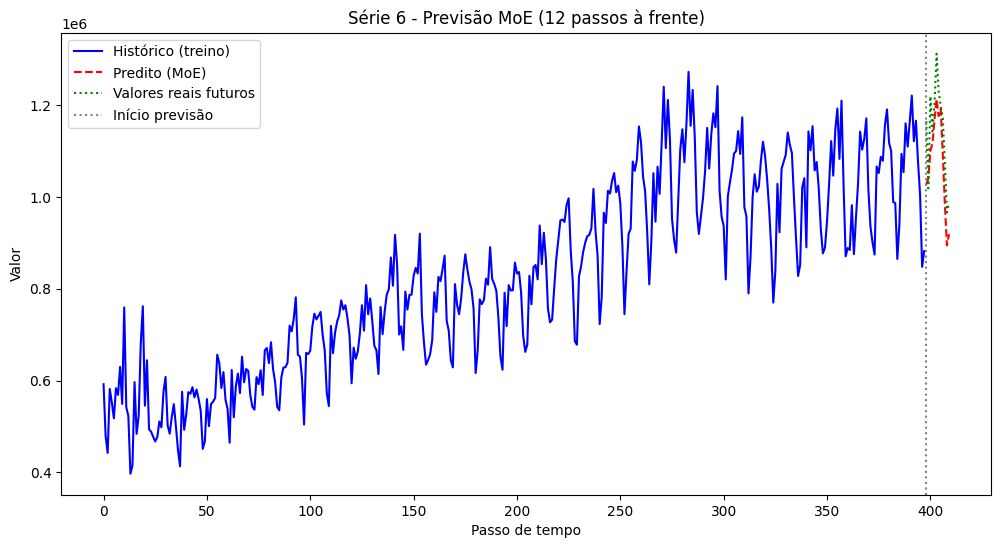

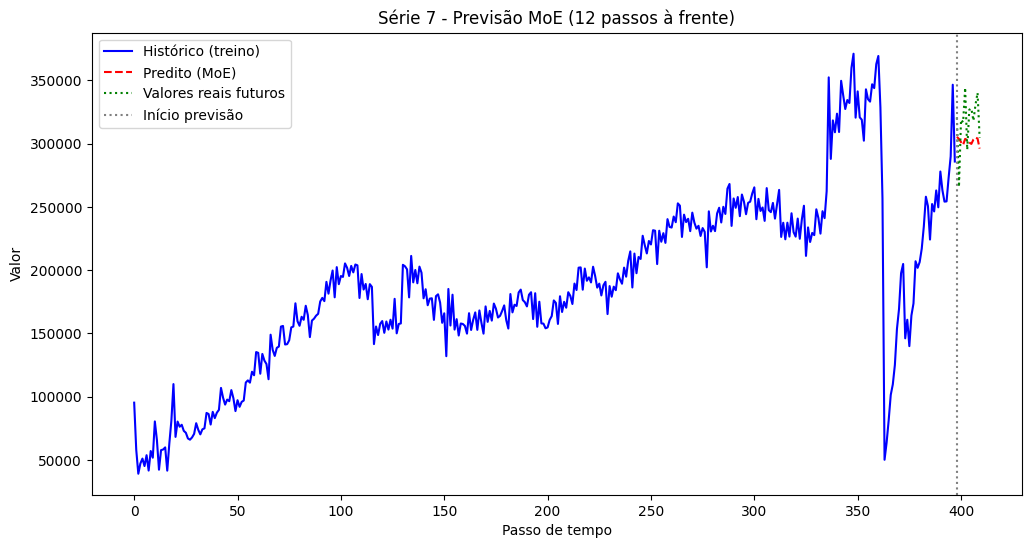

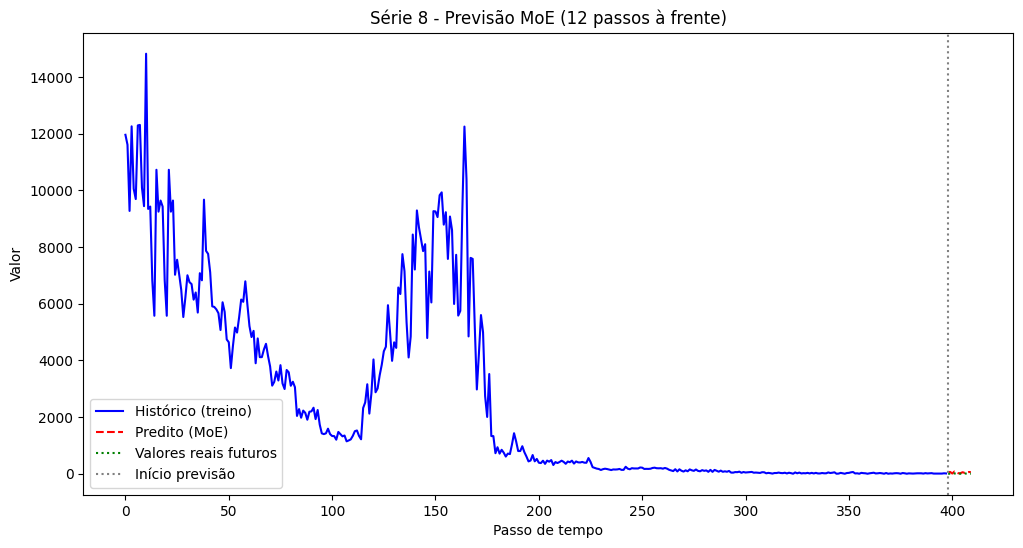

In [21]:
horizon = tensor_test.shape[1]  

num_series = tensor_train.shape[0]

for i in range(num_series):
    series_train = tensor_train[i].numpy()
    series_test = tensor_test[i].numpy()
    pred_moe = output_timesfm[i].numpy()
    
    context_length = len(series_train)
    
    time_axis_context = range(context_length)
    time_axis_pred = range(context_length, context_length + horizon)
    time_axis_real = range(context_length, context_length + horizon)
    
    plt.figure(figsize=(12,6))
    plt.plot(time_axis_context, series_train, label="Histórico (treino)", color="blue")
    plt.plot(time_axis_pred, pred_moe, label="Predito (MoE)", color="red", linestyle="--")
    plt.plot(time_axis_real, series_test, label="Valores reais futuros", color="green", linestyle=":")
    
    plt.axvline(context_length, color="gray", linestyle=":", label="Início previsão")
    plt.legend()
    plt.xlabel("Passo de tempo")
    plt.ylabel("Valor")
    plt.title(f"Série {i+1} - Previsão MoE ({horizon} passos à frente)")
    plt.show()

## Chronos

In [22]:
from chronos import BaseChronosPipeline

model = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-base",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

with torch.no_grad():
    _, output_chronos_scaled = model.predict_quantiles(
        context=tensor_train_scaled,
        prediction_length=prediction_length,
    )

output_chronos = output_chronos_scaled * (max_vals - min_vals) + min_vals

In [23]:
mape_series = (torch.abs((tensor_test - output_chronos) / tensor_test)).mean(dim=1) * 100

for i, mape_val in enumerate(mape_series):
    print(f"Série {i}: MAPE = {mape_val.item():.2f}%")

Série 0: MAPE = 15.81%
Série 1: MAPE = 11.18%
Série 2: MAPE = 11.75%
Série 3: MAPE = 3.28%
Série 4: MAPE = 27.19%
Série 5: MAPE = 6.82%
Série 6: MAPE = 4.64%
Série 7: MAPE = inf%


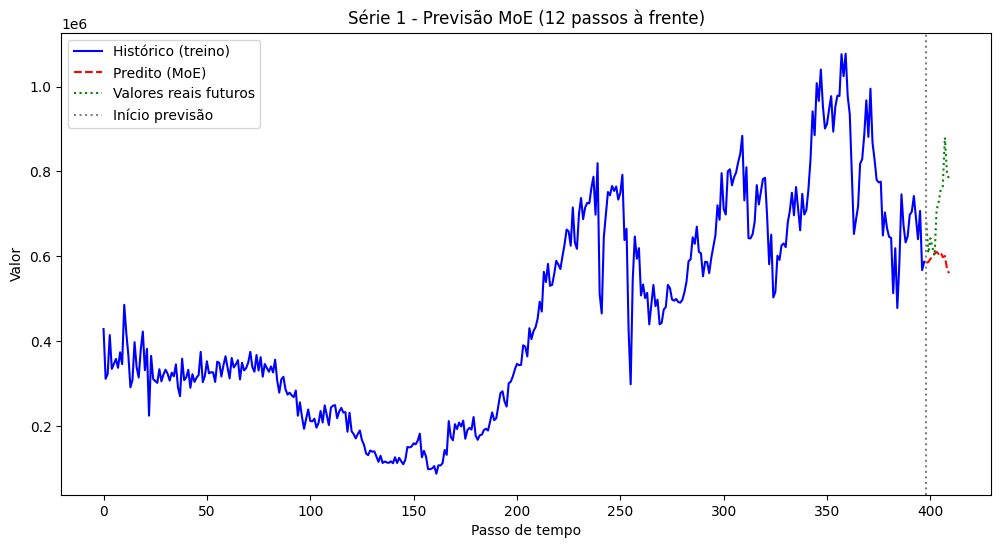

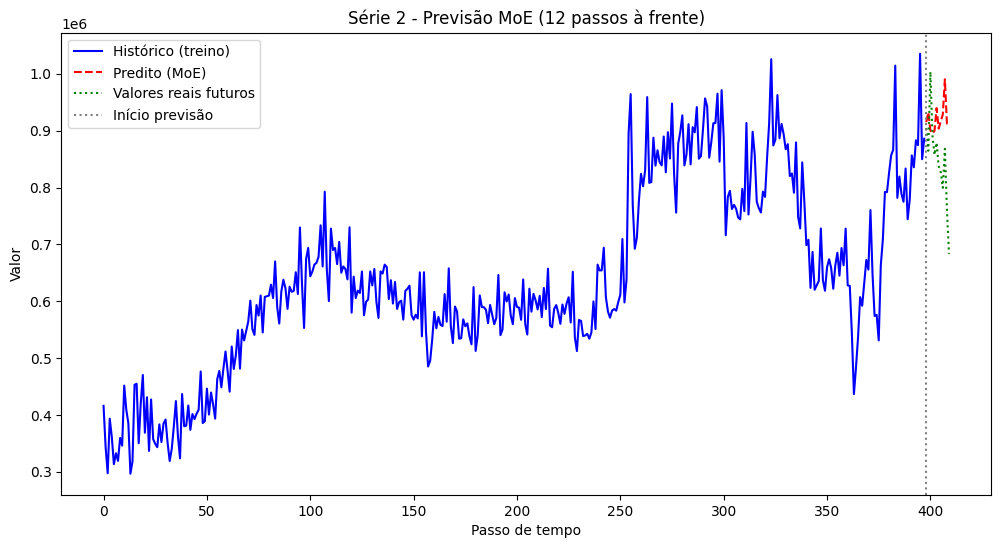

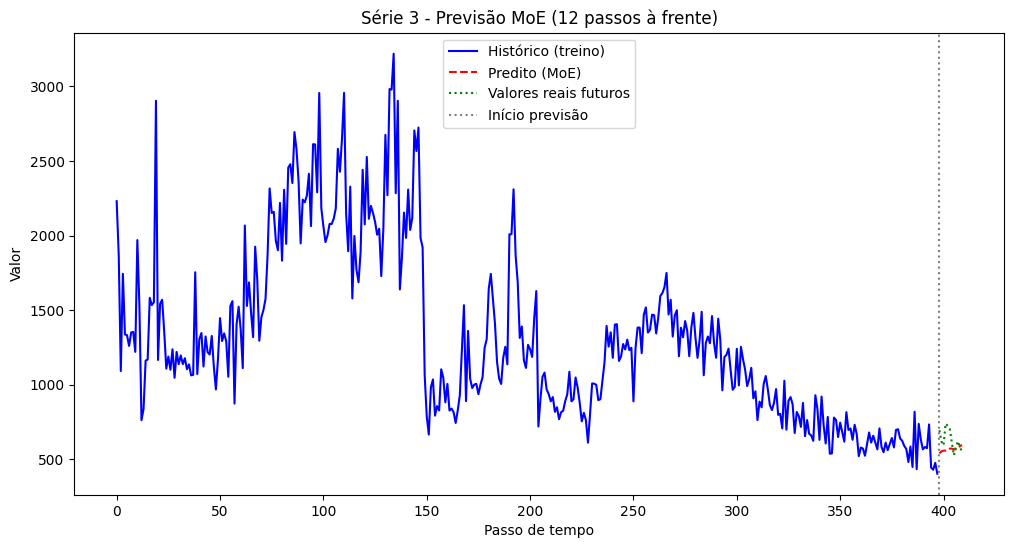

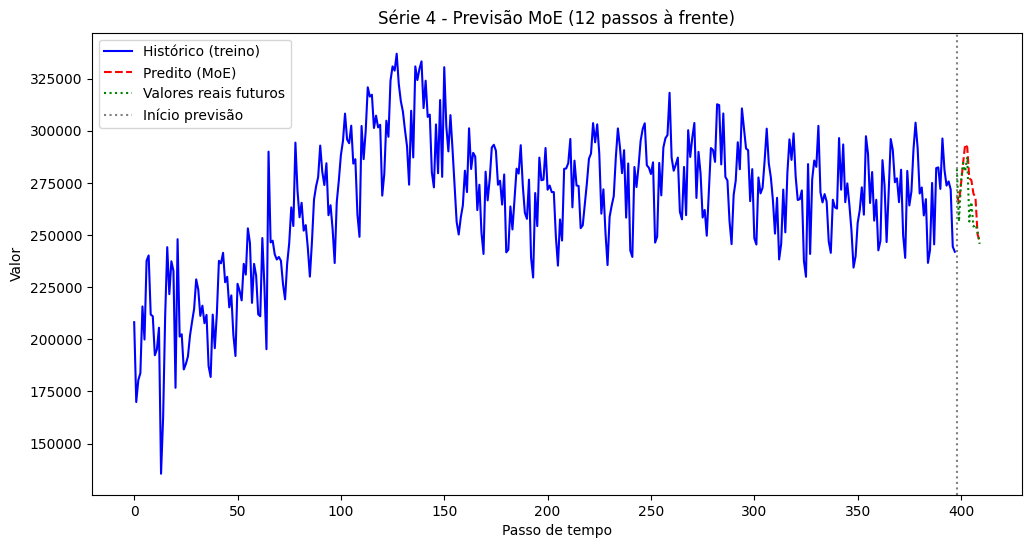

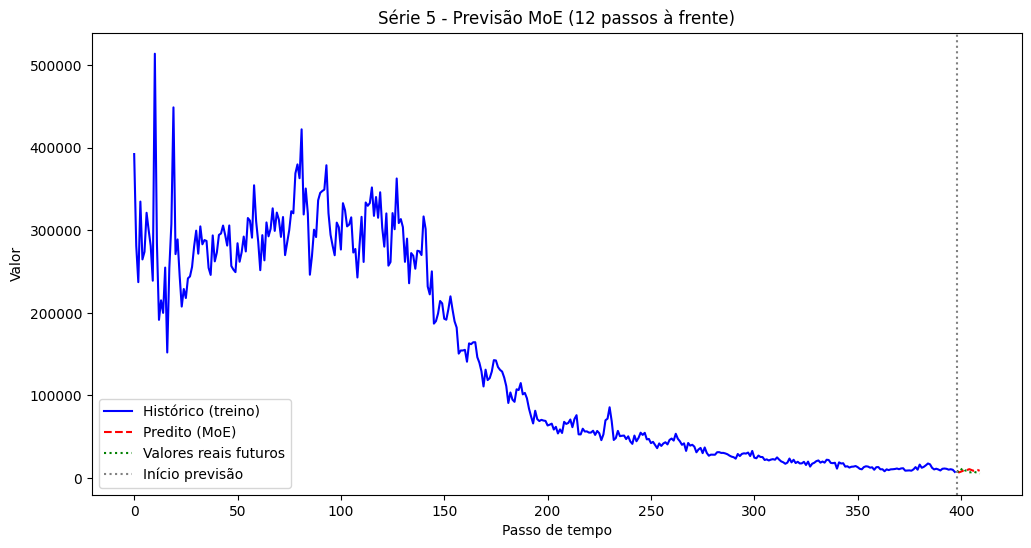

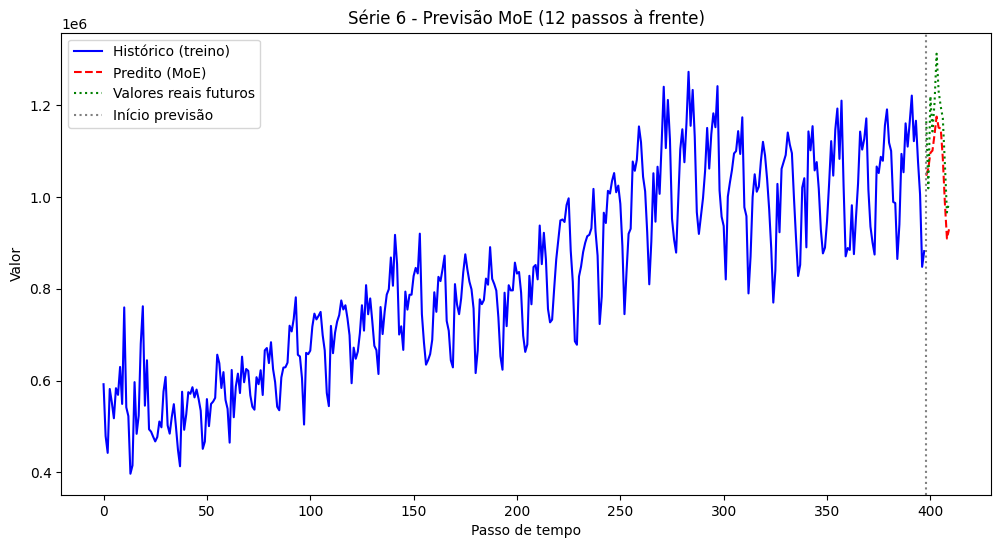

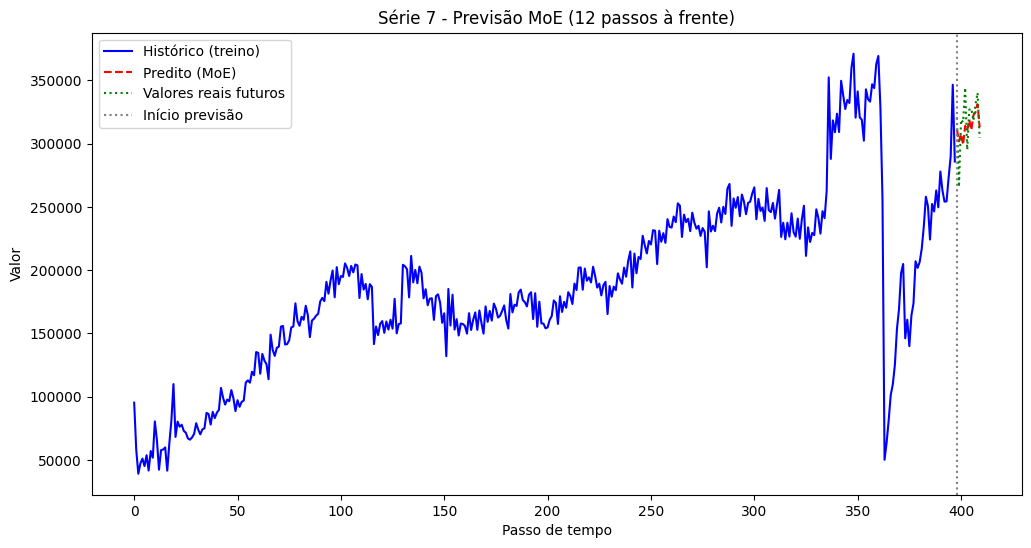

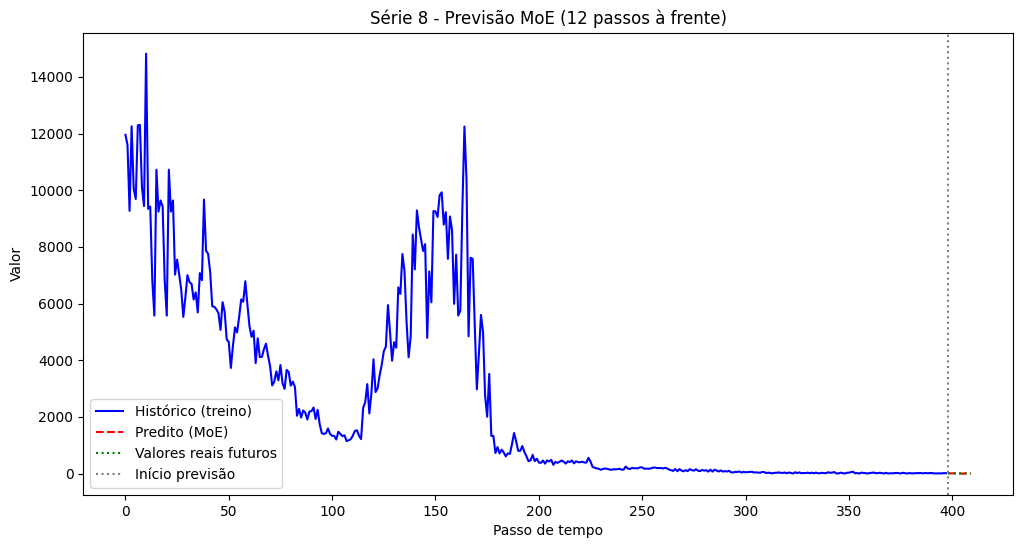

In [24]:
horizon = tensor_test.shape[1]  

num_series = tensor_train.shape[0]

for i in range(num_series):
    series_train = tensor_train[i].numpy()
    series_test = tensor_test[i].numpy()
    pred_moe = output_chronos[i].numpy()
    
    context_length = len(series_train)
    
    time_axis_context = range(context_length)
    time_axis_pred = range(context_length, context_length + horizon)
    time_axis_real = range(context_length, context_length + horizon)
    
    plt.figure(figsize=(12,6))
    plt.plot(time_axis_context, series_train, label="Histórico (treino)", color="blue")
    plt.plot(time_axis_pred, pred_moe, label="Predito (MoE)", color="red", linestyle="--")
    plt.plot(time_axis_real, series_test, label="Valores reais futuros", color="green", linestyle=":")
    
    plt.axvline(context_length, color="gray", linestyle=":", label="Início previsão")
    plt.legend()
    plt.xlabel("Passo de tempo")
    plt.ylabel("Valor")
    plt.title(f"Série {i+1} - Previsão MoE ({horizon} passos à frente)")
    plt.show()

## Moirai

In [25]:
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

model = MoiraiForecast(
            module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-large"),
            prediction_length=prediction_length,
            context_length=context_length,
            patch_size=16,
            num_samples=100,
            target_dim=1,
            feat_dynamic_real_dim=0,
            past_feat_dynamic_real_dim=0,
        )
       
outputs = [] 

for i in range(tensor_train_scaled.size(0)):      
    past_target = tensor_train_scaled[i].unsqueeze(0).unsqueeze(-1)

    past_observed_target = torch.ones_like(past_target, dtype=torch.bool)  
    past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)  

    forecast = model(
        past_target=past_target,
        past_observed_target=past_observed_target,
        past_is_pad=past_is_pad,
    )

    out_row = torch.as_tensor(forecast.mean(dim=1), dtype=torch.float32).reshape(1, -1)
    outputs.append(out_row)

output__moirai_scaled = torch.cat(outputs, dim=0)

output_moirai = output__moirai_scaled * (max_vals - min_vals) + min_vals

In [26]:
mape_series = (torch.abs((tensor_test - output_moirai) / tensor_test)).mean(dim=1) * 100

for i, mape_val in enumerate(mape_series):
    print(f"Série {i}: MAPE = {mape_val.item():.2f}%")

Série 0: MAPE = 15.13%
Série 1: MAPE = 9.01%
Série 2: MAPE = 16.35%
Série 3: MAPE = 4.37%
Série 4: MAPE = 47.52%
Série 5: MAPE = 7.51%
Série 6: MAPE = 5.80%
Série 7: MAPE = inf%


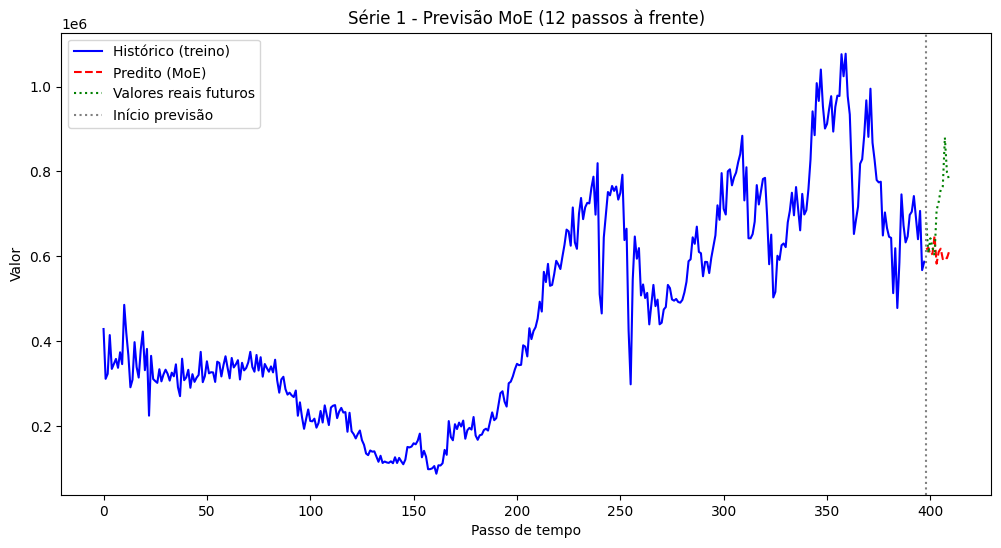

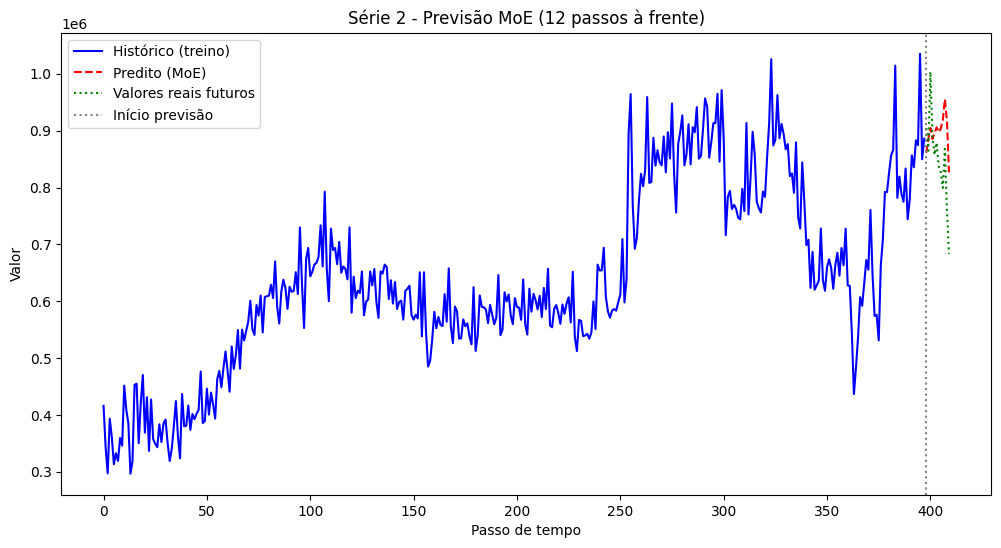

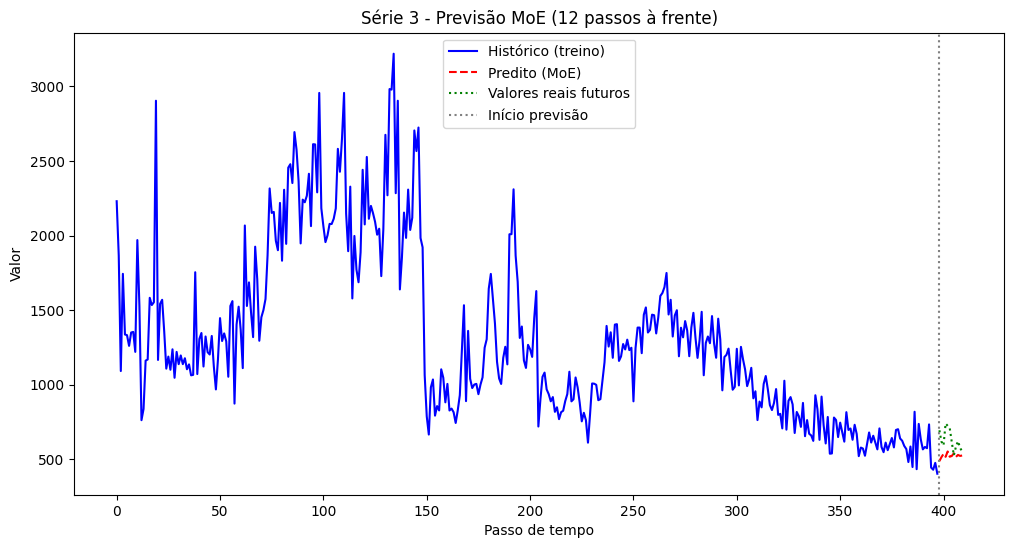

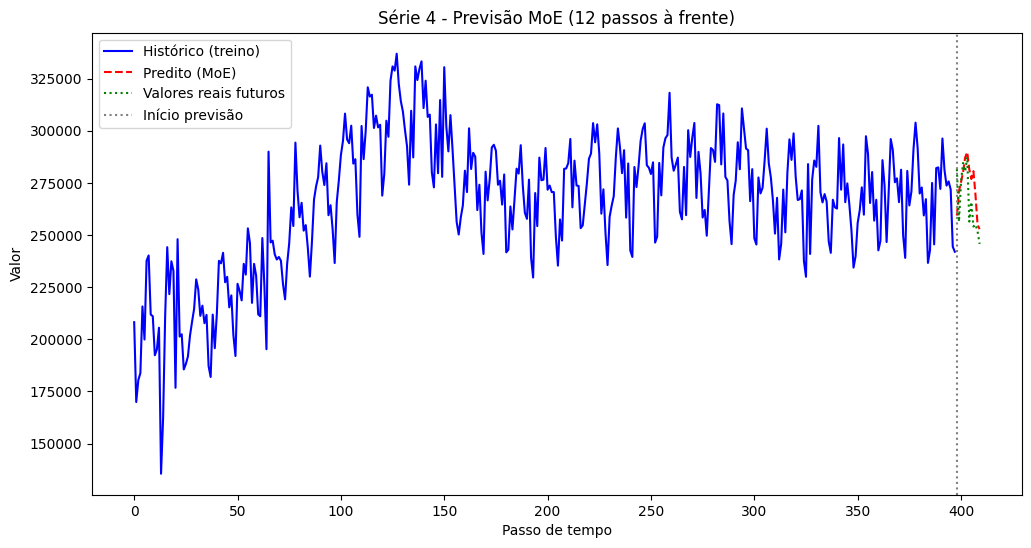

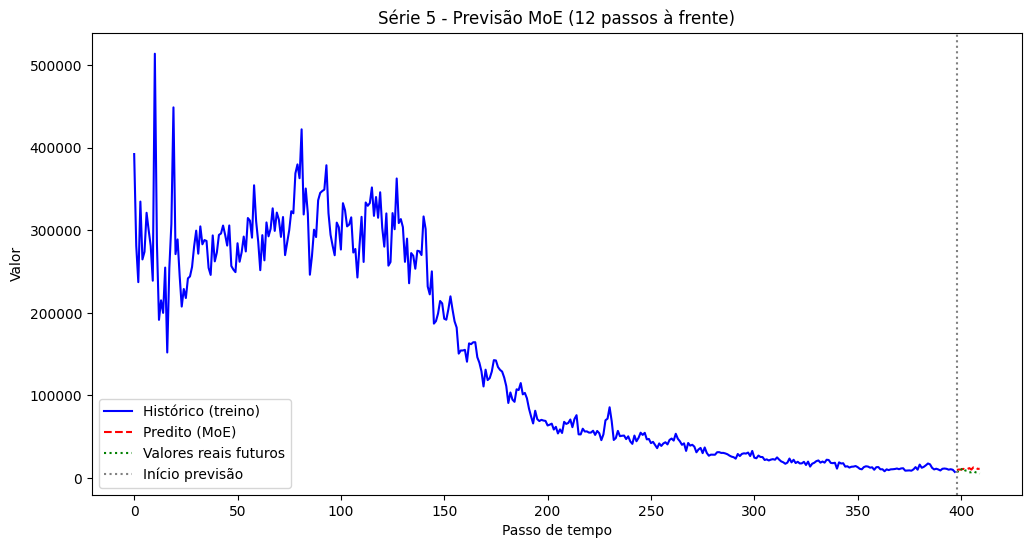

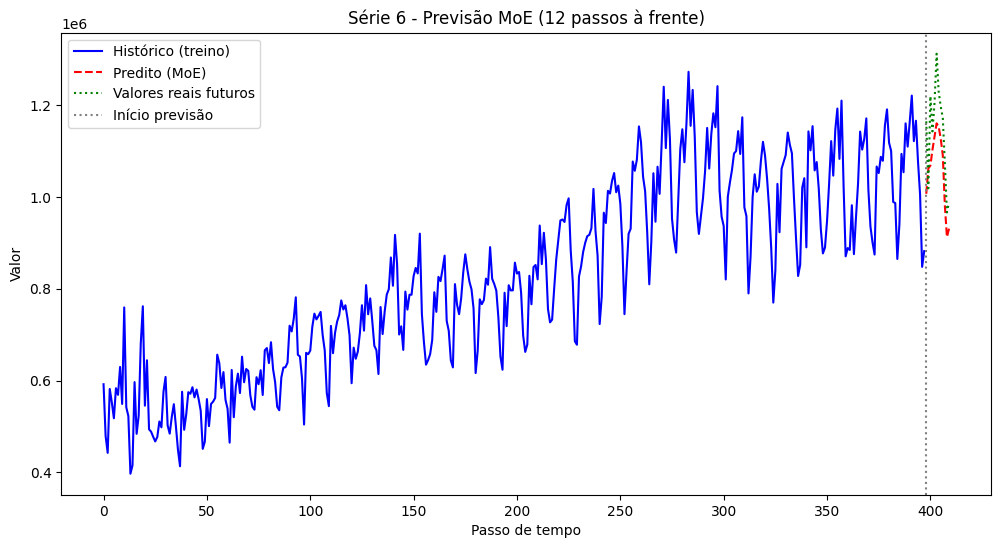

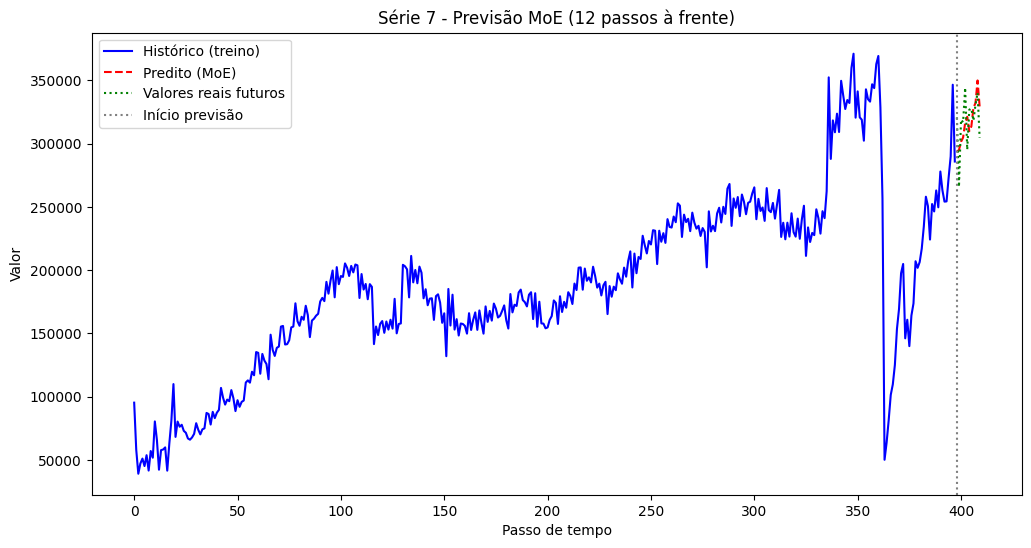

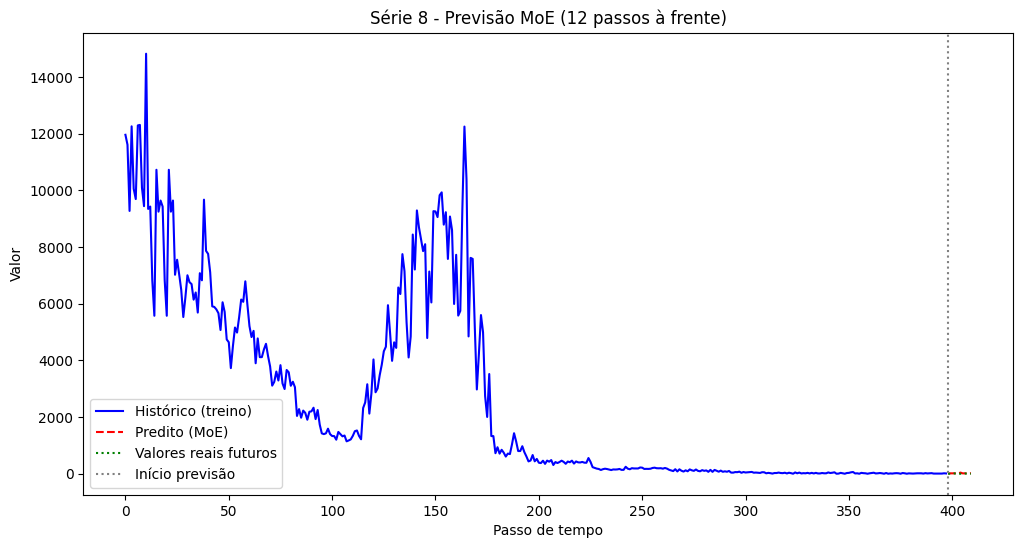

In [27]:
horizon = tensor_test.shape[1]  

num_series = tensor_train.shape[0]

for i in range(num_series):
    series_train = tensor_train[i].numpy()
    series_test = tensor_test[i].numpy()
    pred_moe = output_moirai[i].numpy()
    
    context_length = len(series_train)
    
    time_axis_context = range(context_length)
    time_axis_pred = range(context_length, context_length + horizon)
    time_axis_real = range(context_length, context_length + horizon)
    
    plt.figure(figsize=(12,6))
    plt.plot(time_axis_context, series_train, label="Histórico (treino)", color="blue")
    plt.plot(time_axis_pred, pred_moe, label="Predito (MoE)", color="red", linestyle="--")
    plt.plot(time_axis_real, series_test, label="Valores reais futuros", color="green", linestyle=":")
    
    plt.axvline(context_length, color="gray", linestyle=":", label="Início previsão")
    plt.legend()
    plt.xlabel("Passo de tempo")
    plt.ylabel("Valor")
    plt.title(f"Série {i+1} - Previsão MoE ({horizon} passos à frente)")
    plt.show()

## Moirai-MoE

In [28]:
model = MoiraiForecast(
            # TODO: check what other sizes are available on moirai-moe
            module=MoiraiModule.from_pretrained("Salesforce/moirai-moe-1.0-R-small"),
            prediction_length=prediction_length,
            context_length=context_length,
            patch_size=16,
            num_samples=20,
            target_dim=1,
            feat_dynamic_real_dim=0,
            past_feat_dynamic_real_dim=0,
        )
       
outputs = [] 

for i in range(tensor_train_scaled.size(0)):      
    past_target = tensor_train_scaled[i].unsqueeze(0).unsqueeze(-1)
    print(past_target)

    past_observed_target = torch.ones_like(past_target, dtype=torch.bool)  
    past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)  

    forecast = model(
        past_target=past_target,
        past_observed_target=past_observed_target,
        past_is_pad=past_is_pad,
    )

    out_row = torch.as_tensor(forecast.mean(dim=1), dtype=torch.float32).reshape(1, -1)
    outputs.append(out_row)

output_moiraimoe_scaled = torch.cat(outputs, dim=0)

output_moirai_moe = output_moiraimoe_scaled * (max_vals - min_vals) + min_vals

tensor([[[0.3445],
         [0.2259],
         [0.2379],
         [0.3301],
         [0.2496],
         [0.2615],
         [0.2733],
         [0.2521],
         [0.2891],
         [0.2610],
         [0.4021],
         [0.3354],
         [0.2821],
         [0.2059],
         [0.2236],
         [0.3133],
         [0.2541],
         [0.2290],
         [0.2956],
         [0.3385],
         [0.2465],
         [0.2972],
         [0.1383],
         [0.2807],
         [0.2255],
         [0.2206],
         [0.2164],
         [0.2487],
         [0.2200],
         [0.2364],
         [0.2477],
         [0.2378],
         [0.2217],
         [0.2407],
         [0.2320],
         [0.2604],
         [0.2058],
         [0.1847],
         [0.2739],
         [0.2227],
         [0.2293],
         [0.2475],
         [0.2046],
         [0.2370],
         [0.2187],
         [0.2286],
         [0.2352],
         [0.2901],
         [0.2180],
         [0.2323],
         [0.2676],
         [0.2391],
         [0.

In [29]:
mape_series = (torch.abs((tensor_test - output_moirai_moe) / tensor_test)).mean(dim=1) * 100

for i, mape_val in enumerate(mape_series):
    print(f"Série {i}: MAPE = {mape_val.item():.2f}%")

Série 0: MAPE = 142.71%
Série 1: MAPE = 40.17%
Série 2: MAPE = 386.99%
Série 3: MAPE = 8.30%
Série 4: MAPE = 56400.81%
Série 5: MAPE = 21.54%
Série 6: MAPE = 54.55%
Série 7: MAPE = inf%


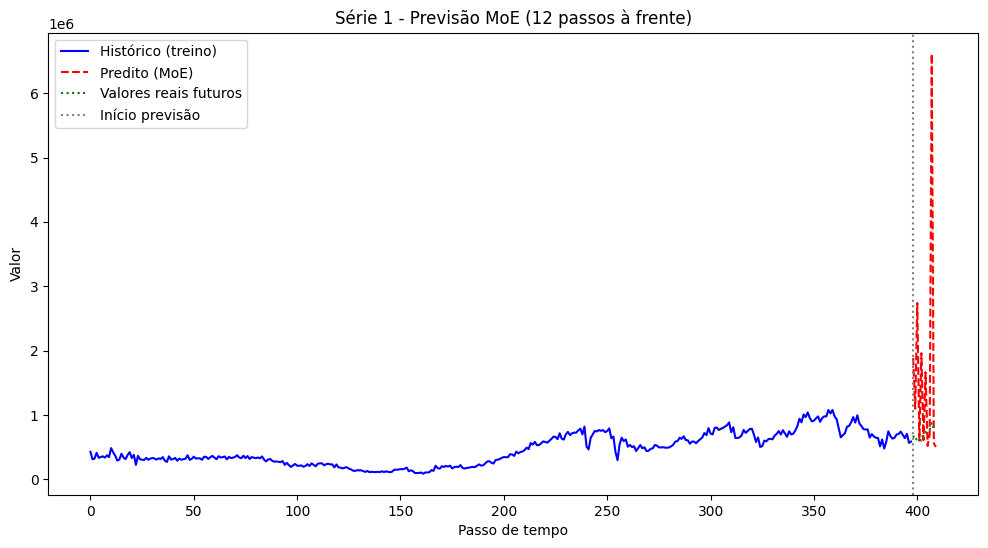

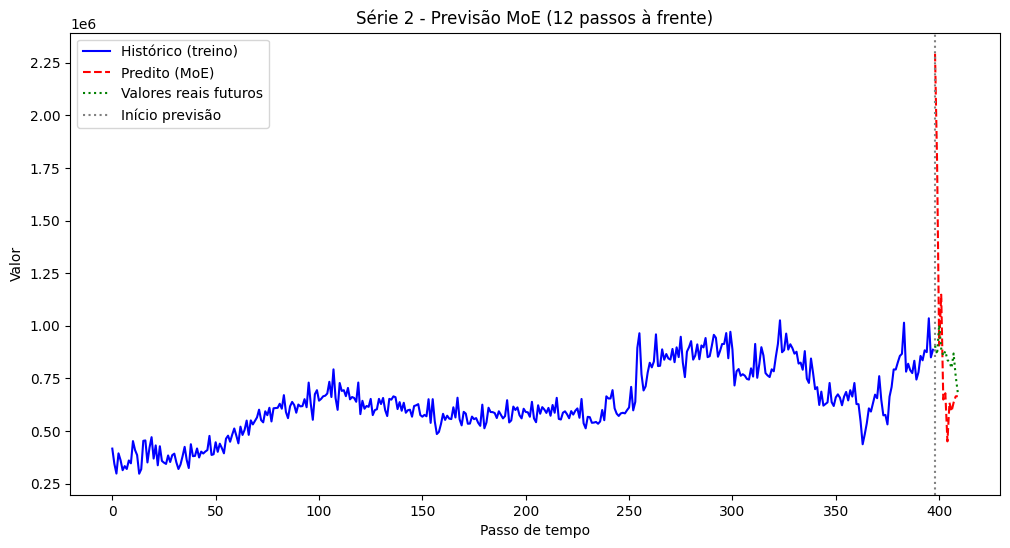

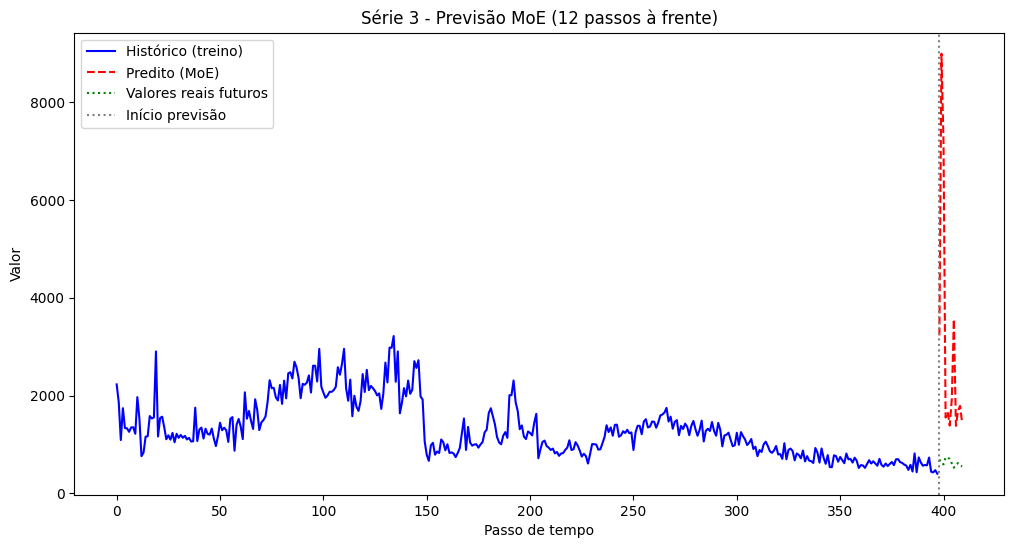

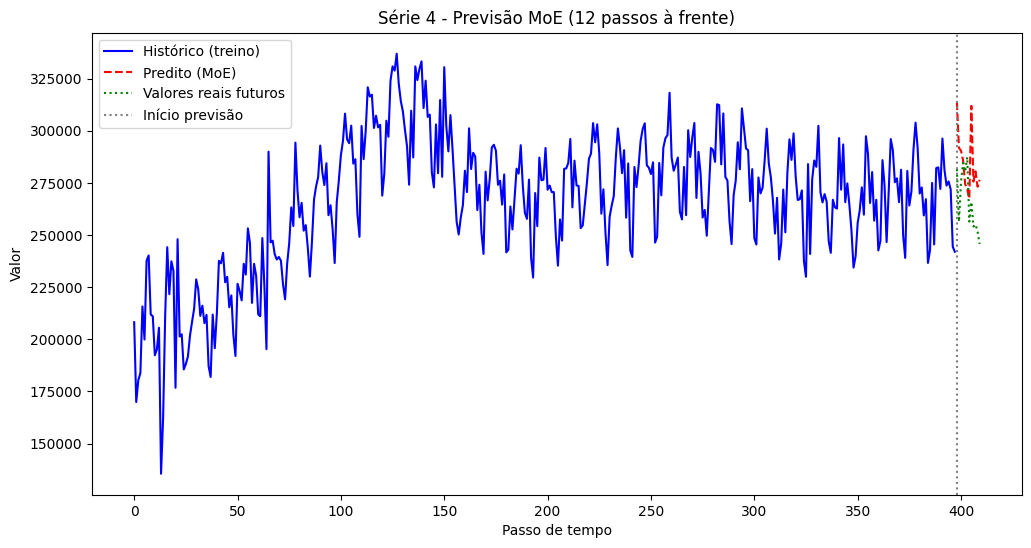

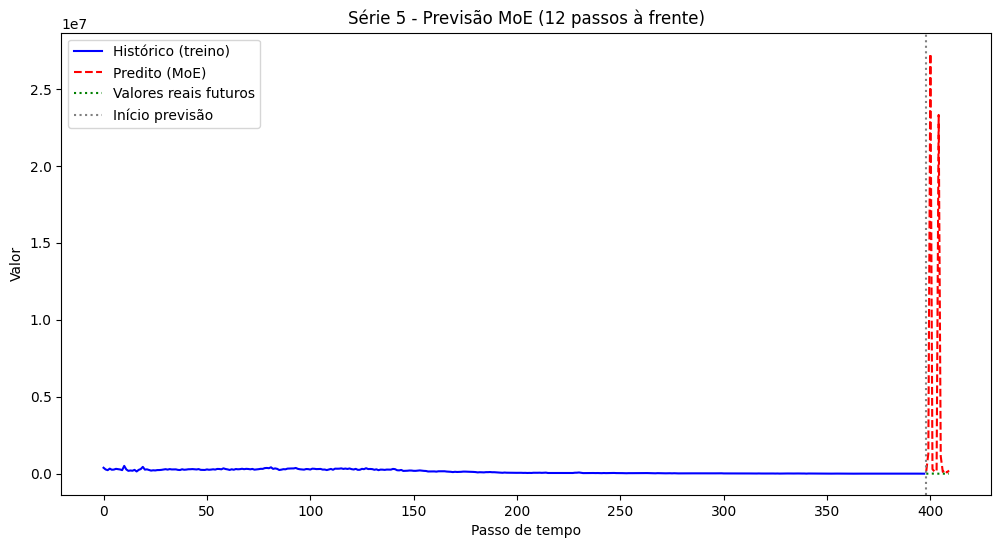

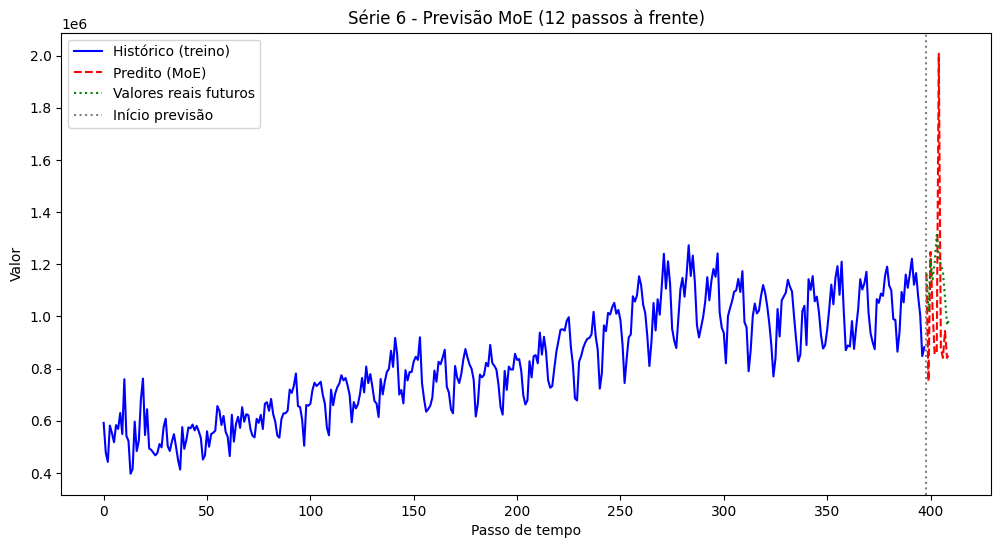

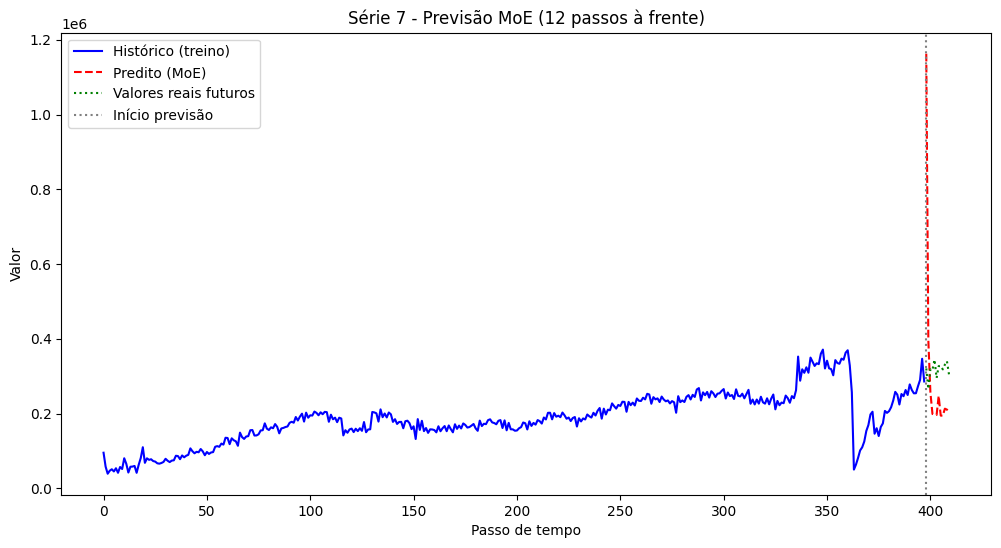

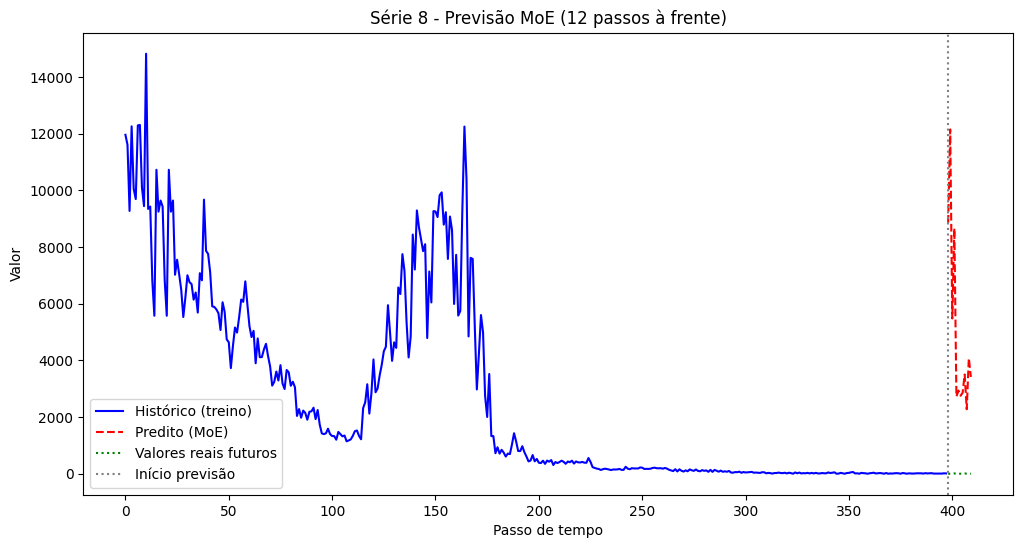

In [30]:
horizon = tensor_test.shape[1]  

num_series = tensor_train.shape[0]

for i in range(num_series):
    series_train = tensor_train[i].numpy()
    series_test = tensor_test[i].numpy()
    pred_moe = output_moirai_moe[i].numpy()
    
    context_length = len(series_train)
    
    time_axis_context = range(context_length)
    time_axis_pred = range(context_length, context_length + horizon)
    time_axis_real = range(context_length, context_length + horizon)
    
    plt.figure(figsize=(12,6))
    plt.plot(time_axis_context, series_train, label="Histórico (treino)", color="blue")
    plt.plot(time_axis_pred, pred_moe, label="Predito (MoE)", color="red", linestyle="--")
    plt.plot(time_axis_real, series_test, label="Valores reais futuros", color="green", linestyle=":")
    
    plt.axvline(context_length, color="gray", linestyle=":", label="Início previsão")
    plt.legend()
    plt.xlabel("Passo de tempo")
    plt.ylabel("Valor")
    plt.title(f"Série {i+1} - Previsão MoE ({horizon} passos à frente)")
    plt.show()

## My MoE

## Summary


In [35]:
model_outputs = {
    "Moirai-MoE": output_moirai_moe,
    "Moirai": output_moirai,
    "Chronos": output_chronos,
    "TimesFM": output_timesfm,
    "Timer": output_timer,
    "Time-MoE": output_time_moe,
}

results = {}
for model_name, preds in model_outputs.items():
    mape_series = (torch.abs((tensor_test - preds) / tensor_test)).mean(dim=1) * 100
    results[model_name] = [round(val.item(), 2) for val in mape_series]

df_results = pd.DataFrame(results).T
df_results.columns = [f"Série {i+1}" for i in range(df_results.shape[1])]
df_results["Média"] = df_results.mean(axis=1).round(2)

print(df_results)

            Série 1  Série 2  Série 3  Série 4   Série 5  Série 6  Série 7  \
Moirai-MoE   142.71    40.17   386.99     8.30  56400.81    21.54    54.55   
Moirai        15.13     9.01    16.35     4.37     47.52     7.51     5.80   
Chronos       15.81    11.18    11.75     3.28     27.19     6.82     4.64   
TimesFM       19.30     8.36    28.29     3.22     55.64     5.88     7.25   
Timer         20.96     7.86    14.16     3.40     99.41     7.89     9.16   
Time-MoE      18.84     7.14    20.47     3.01     63.73     8.55     7.00   

            Série 8  Média  
Moirai-MoE      inf    inf  
Moirai          inf    inf  
Chronos         inf    inf  
TimesFM         inf    inf  
Timer           inf    inf  
Time-MoE        inf    inf  
